In [1]:
from transformers import BertForSequenceClassification
from torch.nn import CrossEntropyLoss, MSELoss

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Using GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Using GPU: TITAN Xp


In [3]:
weights = [1.0, 6.0, 6.0, 6.0]
class_weights = torch.FloatTensor(weights).cuda(device)

In [4]:
class BertForSequenceClassificationWeighted(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        weights=class_weights
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
            If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when :obj:`label` is provided):
            Classification (or regression if config.num_labels==1) loss.
        logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, config.num_labels)`):
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    Examples::
        from transformers import BertTokenizer, BertForSequenceClassification
        import torch
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]
        """

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss(weight=weights)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [5]:
import pandas as pd
df = pd.read_pickle("data/jerome_request_train.pkl")
df = pd.get_dummies(df, columns=['stance'])
df['label'] = df[['stance_unrelated','stance_agree','stance_disagree','stance_discuss']].values.tolist()
df['label'] = df['label'].apply(lambda x: x.index(1))
# grab np values
headlines = df['head'].values
bodies = df['body'].values
labels = df['label'].values


In [6]:
df_val = pd.read_pickle("data/jerome_request_test.pkl")
df_val = pd.get_dummies(df_val, columns=['stance'])
df_val['label'] = df_val[['stance_unrelated','stance_agree','stance_disagree','stance_discuss']].values.tolist()
df_val['label'] = df_val['label'].apply(lambda x: x.index(1))
# grab np values
headlines_val = df_val['head'].values
bodies_val = df_val['body'].values
labels_val = df_val['label'].values


In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading BERT tokenizer...


In [8]:
import torch
# tokenization
input_ids = []
#attention_masks = []

for i in range(len(headlines)):
    encoded_dict = tokenizer.encode(
                        text=headlines[i],                      # headline to encode.
                        text_pair=bodies[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,
                        pad_to_max_length=True,   # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.   
    #input_ids.append(encoded_dict['input_ids'])
    input_ids.append(encoded_dict)
    
    # And its attention mask (simply differentiates padding from non-padding).
    #attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
#attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', headlines[0], bodies[0])
print('Token IDs:', input_ids[0])

Original:  Hundreds of Palestinians flee floods in Gaza as Israel opens dams Hundreds of Palestinians were evacuated from their homes Sunday morning after Israeli authorities opened a number of dams near the border, flooding the Gaza Valley in the wake of a recent severe winter storm.

The Gaza Ministry of Interior said in a statement that civil defense services and teams from the Ministry of Public Works had evacuated more than 80 families from both sides of the Gaza Valley (Wadi Gaza) after their homes flooded as water levels reached more than three meters.

Gaza has experienced flooding in recent days amid a major storm that saw temperatures drop and frigid rain pour down.

The storm displaced dozens and caused hardship for tens of thousands, including many of the approximately 110,000 Palestinians left homeless by Israel's assault over summer.

The suffering is compounded by the fact that Israel has maintained a complete siege over Gaza for the last eight years, severely limiting e

In [9]:
# tokenization
input_ids_val = []
#attention_masks = []

for i in range(len(headlines_val)):
    encoded_dict = tokenizer.encode(
                        text=headlines_val[i],                      # headline to encode.
                        text_pair=bodies_val[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,
                        pad_to_max_length=True,   # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.   
    #input_ids.append(encoded_dict['input_ids'])
    input_ids_val.append(encoded_dict)
    
    # And its attention mask (simply differentiates padding from non-padding).
    #attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_val = torch.cat(input_ids_val, dim=0)
#attention_masks = torch.cat(attention_masks, dim=0)
labels_val = torch.tensor(labels_val)

# Print sentence 0, now as a list of IDs.
print('Original: ', headlines_val[0], bodies_val[0])
print('Token IDs:', input_ids_val[0])

Original:  Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash Danny Boyle is directing the untitled film

Seth Rogen is being eyed to play Apple co-founder Steve Wozniak in Sony’s Steve Jobs biopic.

Danny Boyle is directing the untitled film, based on Walter Isaacson's book and adapted by Aaron Sorkin, which is one of the most anticipated biopics in recent years.

Negotiations have not yet begun, and it’s not even clear if Rogen has an official offer, but the producers — Scott Rudin, Guymon Casady and Mark Gordon — have set their sights on the talent and are in talks.

Of course, this may all be for naught as Christian Bale, the actor who is to play Jobs, is still in the midst of closing his deal. Sources say that dealmaking process is in a sensitive stage.

Insiders say Boyle will is flying to Los Angeles to meet with actress to play one of the female leads, an assistant to Jobs. Insiders say that Jessica Chastain is on

In [10]:
from torch.utils.data import TensorDataset, random_split

train_dataset = TensorDataset(input_ids, labels)
val_dataset = TensorDataset(input_ids_val, labels_val)
train_size = len(train_dataset)
val_size = len(val_dataset)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

45,437 training samples
4,535 validation samples


In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [12]:
from transformers import AdamW, BertConfig

model = BertForSequenceClassificationWeighted.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda(device)

BertForSequenceClassificationWeighted(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [14]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [15]:
import numpy as np

# Function to calculate fnc score and max fnc score
def fnc_score(preds, labels):
    y_pred = np.argmax(preds, axis=1).flatten()
    y_true = labels.flatten()

    # compute max_score = 0.25*unrelated + (agree+disagree+discuss)
    total_count = torch.tensor(len(y_true))
    unrelated_count = torch.sum(y_true == 0)
    related_count = total_count - unrelated_count
    max_score = 0.25 * unrelated_count + related_count

    # compute score
    unrelated_pred = y_pred == 0
    unrelated_true = y_true == 0
    correct_unrelated_count = torch.sum(unrelated_pred & unrelated_true)
    correct_unrelated_count_score = 0.25 * correct_unrelated_count

    is_related_mask = ~unrelated_pred
    is_correct_mask = y_true == y_pred

    combined_mask_correct_related = is_related_mask & is_correct_mask
    correct_related_count = torch.sum(combined_mask_correct_related)
    correct_related_count_score = 1.0 * correct_related_count

    is_related_true_mask = ~unrelated_true
    combined_mask_related = is_related_mask & is_related_true_mask
    combined_mask_incorrect_related = combined_mask_related & ~combined_mask_correct_related
    incorrect_related_count = torch.sum(combined_mask_incorrect_related)
    incorrect_related_count_score = 0.25 * incorrect_related_count

    score = correct_unrelated_count_score + correct_related_count_score + incorrect_related_count_score
    return score, max_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return torch.sum(pred_flat == labels_flat).double() / len(labels_flat)

In [16]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
def train(model, epochs, train_dataloader, validation_dataloader, device):
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 100 batches.
            if step % 100 == 0 and step != 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            #b_input_mask = batch[1].to(device)
            b_labels = batch[1].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            loss, logits = model(input_ids=b_input_ids,
                                 labels=b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_fnc_score = 0
        total_eval_max_fnc_score = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            #b_input_mask = batch[1].to(device)
            b_labels = batch[1].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       labels=b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu()
            label_ids = b_labels.to('cpu')

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)

            # Calculate FNC score, max FNC score for this batch, and accumulate
            b_fnc_score, b_max_fnc_score = fnc_score(logits, label_ids)
            total_eval_fnc_score += b_fnc_score
            total_eval_max_fnc_score += b_max_fnc_score

        # Report the final accuracy for this validation run.
        avg_val_accuracy = (total_eval_accuracy / len(validation_dataloader)).item()
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Report fnc scores over validation run
        total_eval_fnc_score = total_eval_fnc_score.item()
        total_eval_max_fnc_score = total_eval_max_fnc_score.item()
        relative_score = total_eval_fnc_score / total_eval_max_fnc_score
        print("  FNC Score: {0:.2f}".format(total_eval_fnc_score))
        print("  Maximum Possible FNC Score: {0:.2f}".format(total_eval_max_fnc_score))
        print("  Relative FNC Score: {0:.2f}".format(total_eval_fnc_score / total_eval_max_fnc_score))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time,
                'Valid. FNC Score': total_eval_fnc_score,
                'Valid. Max FNC Score': total_eval_max_fnc_score,
                'Relative FNC Score': relative_score
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [18]:
training_stats = train(model, epochs, train_dataloader, validation_dataloader, device)


======== Epoch 1 / 10 ========
Training...


/opt/conda/conda-bld/pytorch_1587428094786/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch   100  of  1,420.    Elapsed: 0:00:32.
  Batch   200  of  1,420.    Elapsed: 0:01:05.
  Batch   300  of  1,420.    Elapsed: 0:01:38.
  Batch   400  of  1,420.    Elapsed: 0:02:10.
  Batch   500  of  1,420.    Elapsed: 0:02:43.
  Batch   600  of  1,420.    Elapsed: 0:03:16.
  Batch   700  of  1,420.    Elapsed: 0:03:50.
  Batch   800  of  1,420.    Elapsed: 0:04:23.
  Batch   900  of  1,420.    Elapsed: 0:04:57.
  Batch 1,000  of  1,420.    Elapsed: 0:05:31.
  Batch 1,100  of  1,420.    Elapsed: 0:06:05.
  Batch 1,200  of  1,420.    Elapsed: 0:06:38.
  Batch 1,300  of  1,420.    Elapsed: 0:07:12.
  Batch 1,400  of  1,420.    Elapsed: 0:07:46.

  Average training loss: 0.44
  Training epoch took: 0:07:53

Running Validation...
  Accuracy: 0.94
  FNC Score: 1845.00
  Maximum Possible FNC Score: 2061.50
  Relative FNC Score: 0.89
  Validation Loss: 0.55
  Validation took: 0:00:16

======== Epoch 2 / 10 ========
Training...
  Batch   100  of  1,420.    Elapsed: 0:00:34.
  Batch   20

  Accuracy: 0.95
  FNC Score: 1896.25
  Maximum Possible FNC Score: 2061.50
  Relative FNC Score: 0.92
  Validation Loss: 0.98
  Validation took: 0:00:16

======== Epoch 10 / 10 ========
Training...
  Batch   100  of  1,420.    Elapsed: 0:00:34.
  Batch   200  of  1,420.    Elapsed: 0:01:07.
  Batch   300  of  1,420.    Elapsed: 0:01:41.
  Batch   400  of  1,420.    Elapsed: 0:02:15.
  Batch   500  of  1,420.    Elapsed: 0:02:49.
  Batch   600  of  1,420.    Elapsed: 0:03:22.
  Batch   700  of  1,420.    Elapsed: 0:03:56.
  Batch   800  of  1,420.    Elapsed: 0:04:30.
  Batch   900  of  1,420.    Elapsed: 0:05:04.
  Batch 1,000  of  1,420.    Elapsed: 0:05:37.
  Batch 1,100  of  1,420.    Elapsed: 0:06:11.
  Batch 1,200  of  1,420.    Elapsed: 0:06:45.
  Batch 1,300  of  1,420.    Elapsed: 0:07:19.
  Batch 1,400  of  1,420.    Elapsed: 0:07:52.

  Average training loss: 0.00
  Training epoch took: 0:07:59

Running Validation...
  Accuracy: 0.95
  FNC Score: 1877.00
  Maximum Possible F

In [19]:
import matplotlib.pyplot as plt

In [20]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.44421187409062046,
  'Valid. Loss': 0.5450819786933159,
  'Valid. Accur.': 0.9370598591549296,
  'Training Time': '0:07:53',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': 1845.0,
  'Valid. Max FNC Score': 2061.5,
  'Relative FNC Score': 0.8949793839437303},
 {'epoch': 2,
  'Training Loss': 0.1661823774752712,
  'Valid. Loss': 0.6281586980215982,
  'Valid. Accur.': 0.9418152939375383,
  'Training Time': '0:07:59',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': 1864.25,
  'Valid. Max FNC Score': 2061.5,
  'Relative FNC Score': 0.904317244724715},
 {'epoch': 3,
  'Training Loss': 0.08809003570376531,
  'Valid. Loss': 0.8940620161838908,
  'Valid. Accur.': 0.9341128291488059,
  'Training Time': '0:07:58',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': 1827.25,
  'Valid. Max FNC Score': 2061.5,
  'Relative FNC Score': 0.886369148678147},
 {'epoch': 4,
  'Training Loss': 0.048242748735161434,
  'Valid. Loss': 0.7760914488357179,
  'Val

In [21]:
epoch = [x['epoch'] for x in training_stats]
training_loss = [x['Training Loss'] for x in training_stats]
validation_loss  = [x['Valid. Loss'] for x in training_stats]
relative_validation_fnc = [x['Relative FNC Score'] for x in training_stats]
validation_accuracy = [x['Valid. Accur.'] for x in training_stats]

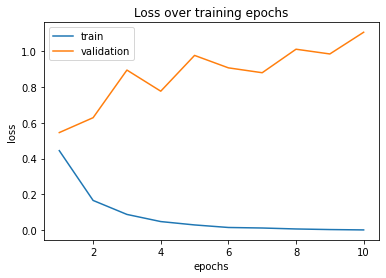

In [22]:
plt.plot(epoch, training_loss, label='train')
plt.plot(epoch, validation_loss, label='validation')
plt.title('Loss over training epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss_128_w6.png')

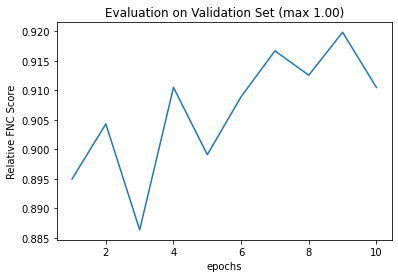

In [23]:
plt.plot(epoch, relative_validation_fnc)
plt.title('Evaluation on Validation Set (max 1.00)')
plt.xlabel('epochs')
plt.ylabel('Relative FNC Score')
plt.savefig('fnc_128_w6.png')

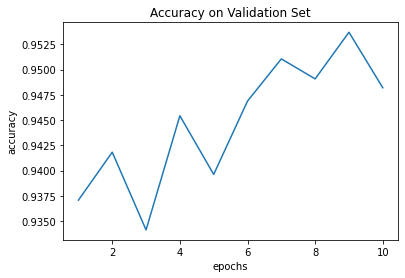

In [24]:
plt.plot(epoch, validation_accuracy)
plt.title('Accuracy on Validation Set')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('accuracy_128_w6.png')

In [25]:
import pickle
with open('training_stats_128_w6.pkl', 'wb') as f:
    pickle.dump(training_stats, f)